# Assignment 3
```
- Sensing, Perception and Actuation, Innopolis University (Fall semester 2021)
- Name : Ivan Efremov
- Email : i.efremov@innopolis.university
```

# Task 1
![](Task1_desc.png)

## Find fundamental matrix

  So first we need to find as many possible matches between two images to find the fundamental matrix. For this, we use SIFT descriptors with FLANN based matcher and ratio test.

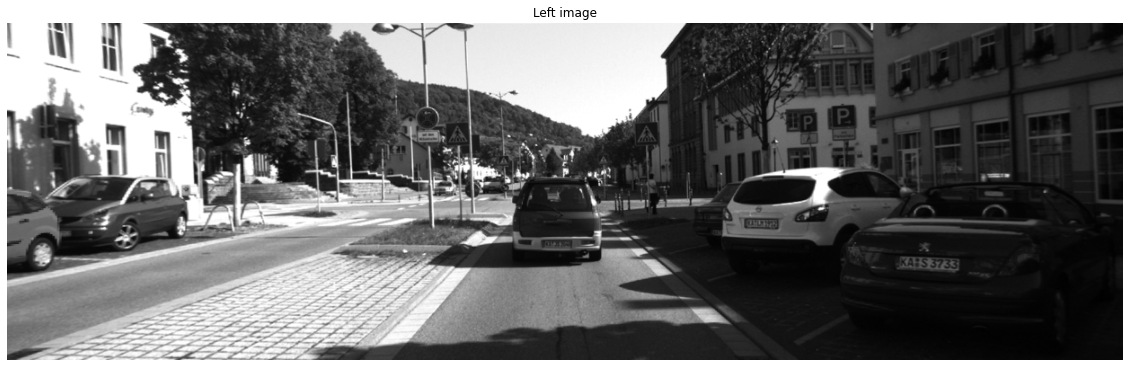

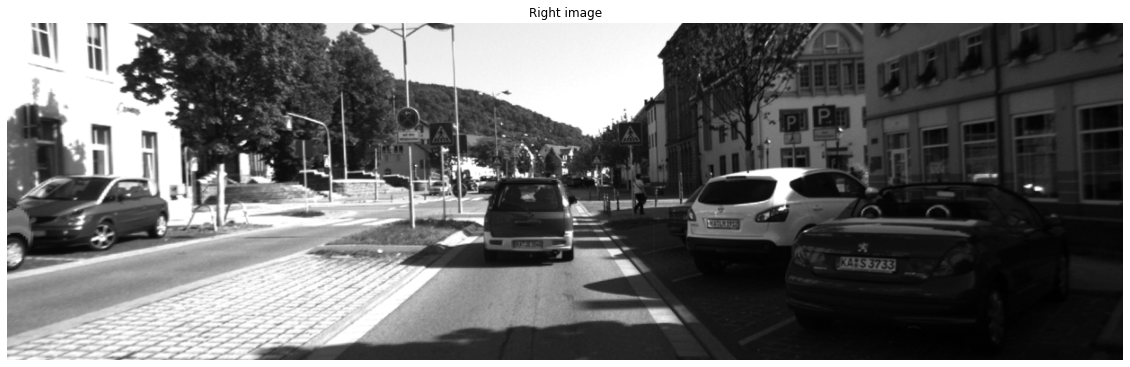

In [1]:
# Code was taken from OpenCV tutorial: 
# https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html

import cv2
import numpy as np
from matplotlib import pyplot as plt

#Read images
img1 = cv2.imread('left.png', 0)  #queryimage # left image
img2 = cv2.imread('right.png', 0 ) #trainimage # right image

plt.figure(figsize=(20,10))
plt.imshow(img1, cmap='gray')
plt.title("Left image")
plt.axis('off')
plt.show()
plt.figure(figsize=(20,10))
plt.title("Right image")
plt.axis('off')
plt.imshow(img2, cmap='gray')
plt.show()

In [2]:
sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < 0.80*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

Now we have the list of best matches from both the images. Let's find the Fundamental Matrix.

In [3]:
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_8POINT)
print("Fundamental matrix:\n", F)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

Fundamental matrix:
 [[ 1.14505814e-06  3.14432411e-04 -4.67201962e-02]
 [-3.07186172e-04  6.66193627e-05  3.54425077e-01]
 [ 4.43566152e-02 -3.71286468e-01  1.00000000e+00]]


Next we find the epilines. Epilines corresponding to the points in first image is drawn on second image. So mentioning of correct images are important here. We get an array of lines. So we define a new function to draw these lines on the images.

In [4]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1, img2

Now we find the epilines in both the images and draw them.

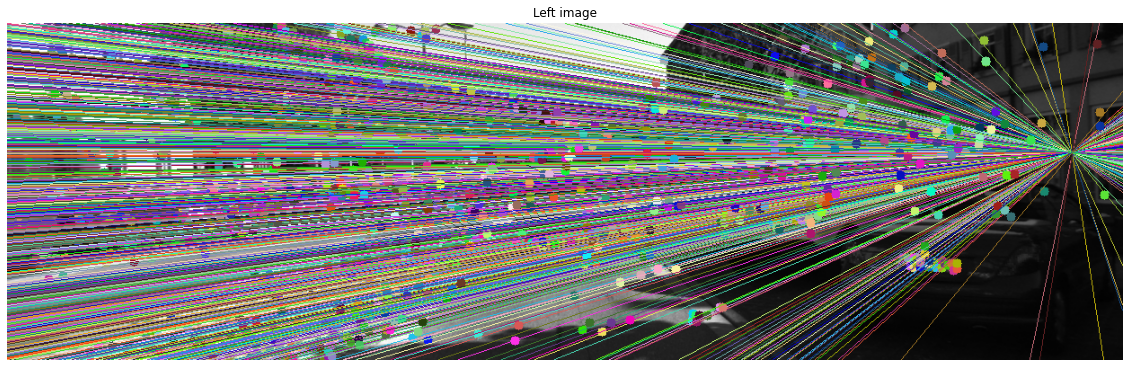

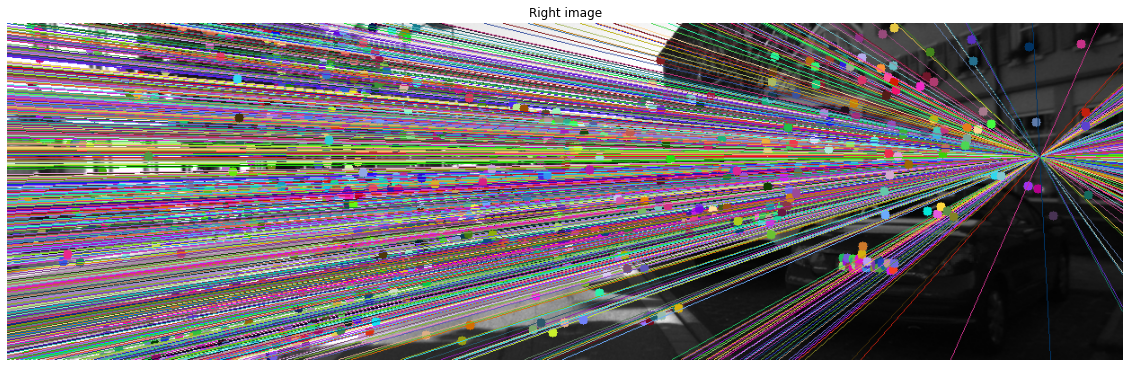

In [5]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, F)
lines1 = lines1.reshape(-1,3)
img5, img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1, F)
lines2 = lines2.reshape(-1,3)
img3, img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.figure(figsize=(20,10))
plt.imshow(img5)
plt.title("Left image")
plt.axis('off')
plt.show()
plt.figure(figsize=(20,10))
plt.title("Right image")
plt.axis('off')
plt.imshow(img3)
plt.show()

##  Compute disparity map

![](stereo_depth.jpg)

$$ disparity = x - x' = \frac{Bf}{Z}$$

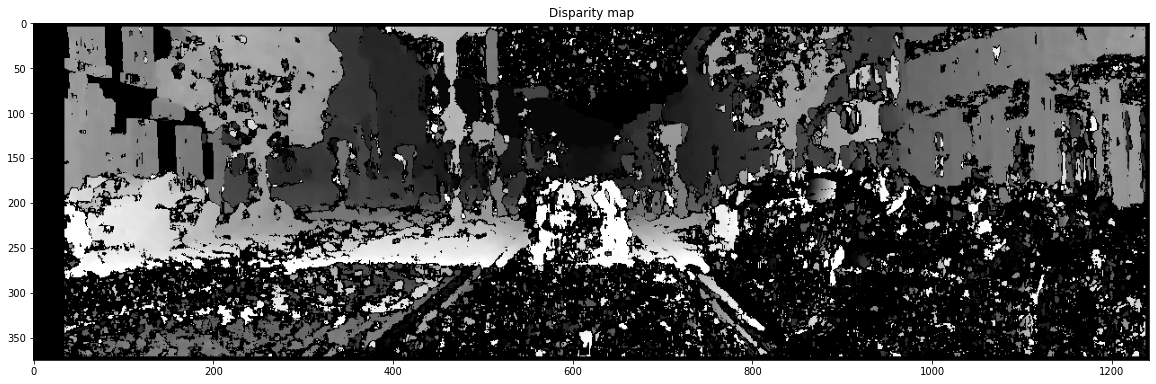

In [6]:
# Credits to OpenCV tutorial:
# https://docs.opencv.org/4.x/dd/d53/tutorial_py_depthmap.html

img1 = cv2.imread('left.png', 0)  
img2 = cv2.imread('right.png', 0) 

stereo = cv2.StereoBM_create(32, 9)
disparity = stereo.compute(img1, img2)

plt.figure(figsize=(20, 10))
plt.imshow(disparity, 'gray')
plt.title("Disparity map")
plt.show()

# Task 2

![](Task2_desc.png)

## Collect data

I took depth and colored photos using depth camera. 

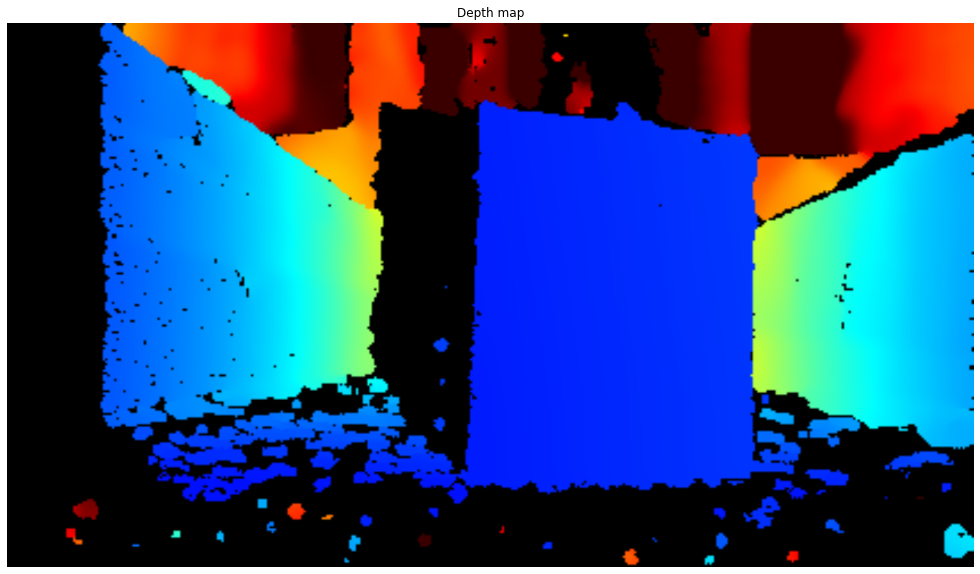

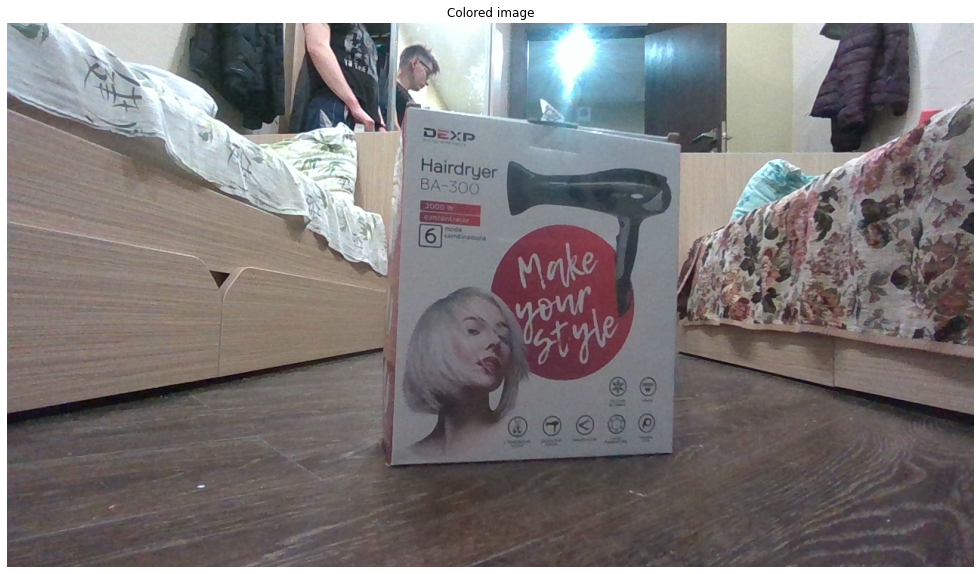

In [7]:
import cv2
from matplotlib import pyplot as plt

color_img = cv2.imread('color.png')
color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)

depth_map = cv2.imread('depth_map.png')
depth_map = cv2.cvtColor(depth_map, cv2.COLOR_BGR2RGB)
depth_map = cv2.resize(depth_map,(color_img.shape[1], color_img.shape[0]))

plt.figure(figsize=(20, 10))
plt.imshow(depth_map)
plt.axis('off')
plt.title("Depth map")
plt.show()

plt.figure(figsize=(20, 10))
plt.imshow(color_img)
plt.axis('off')
plt.title("Colored image")
plt.show()

## Extract object from depth map

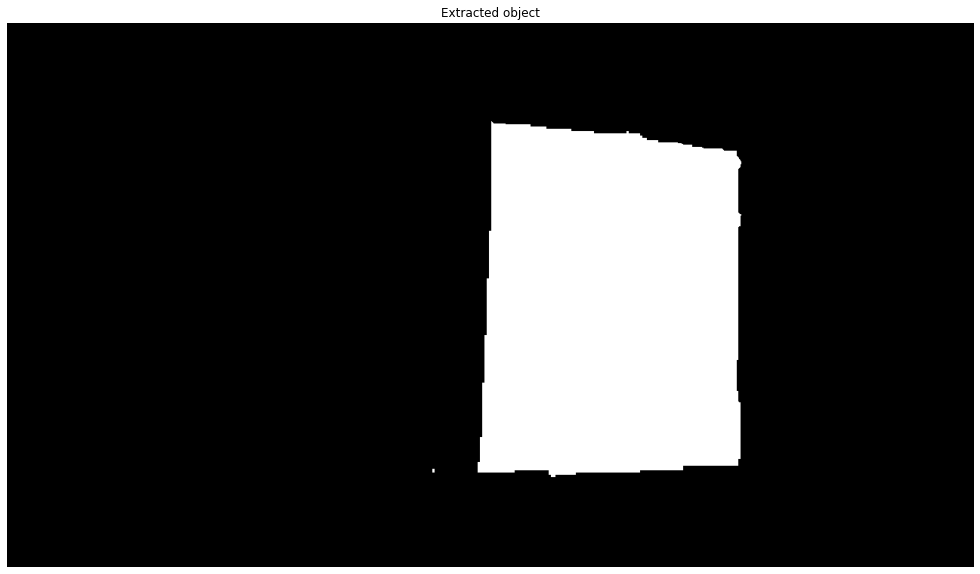

In [8]:
import numpy as np

frame_HSV = cv2.cvtColor(depth_map, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(frame_HSV, (112, 0, 0), (120, 255, 255))
target = cv2.bitwise_and(depth_map,depth_map, mask=mask)


kernel = np.ones((3, 3))/2
mask = cv2.dilate(mask, kernel, iterations = 2)
mask = cv2.erode(mask, kernel, iterations = 20)

plt.figure(figsize=(20, 10))
plt.imshow(mask, 'gray')
plt.axis('off')
plt.title("Extracted object")
plt.show()

## Draw contour with center point

In [9]:
contours,hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

contour = []
for c in contours:
    if cv2.contourArea(c) < 100:
        continue
    c[:,:,0] -= 100
    c[:,:,1] -= 15
    contour.append(c)

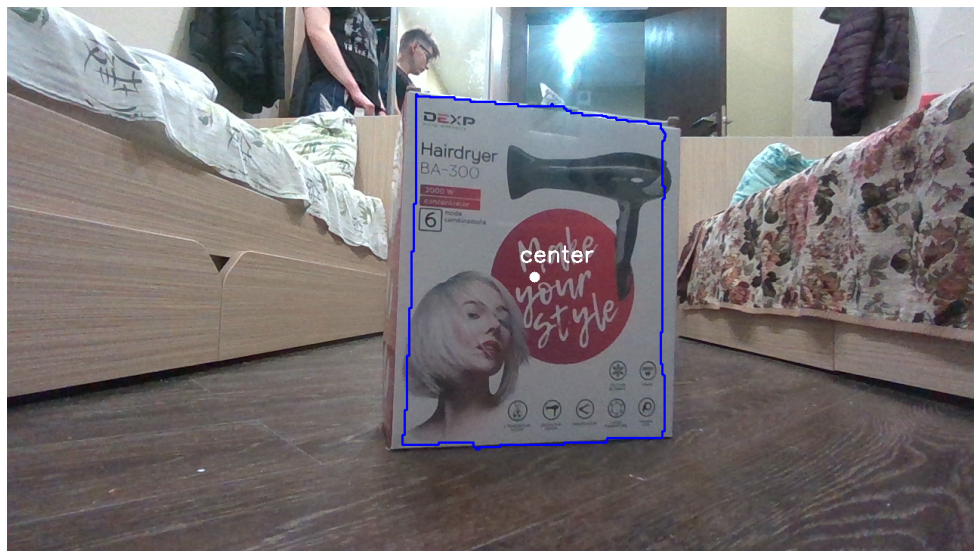

In [10]:
color_img_copy = color_img.copy()

cv2.drawContours(color_img_copy,contour,0,(0,0,255),2)
M = cv2.moments(contour[0])
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
cv2.circle(color_img_copy, (cX, cY), 7, (255, 255, 255), -1)
cv2.putText(color_img_copy, "center", (cX - 20, cY - 20),
    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

plt.figure(figsize=(20, 10))
plt.imshow(color_img_copy)
plt.axis('off')
plt.show()

# Task 3

![](Task3_desc.png)

## Read data

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utm

# read the data from both sensors: GPS and accelerometer

acc_data = 'sensordata/accelerometer.csv'
gps_data = 'sensordata/gps.csv'

acc_data = pd.read_csv(acc_data)
gps_data = pd.read_csv(gps_data)


lat = gps_data['lat'].values
lon = gps_data['lng'].values

# Convert lat and lng measurements into world coordinates

gps_x, gps_y, lon_zone, lat_zone = utm.from_latlon(lat, lon)

ddx = acc_data['x'].values
ddy = acc_data['y'].values

gps_time = gps_data['time'].values
acc_time = acc_data['time'].values

### Plot data

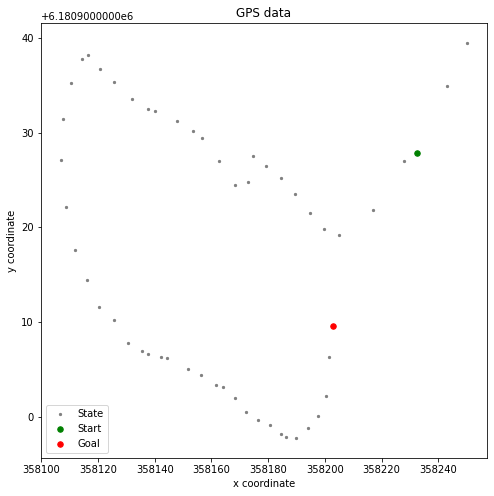

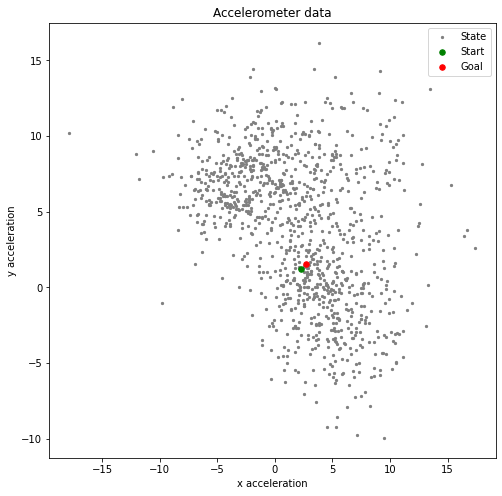

In [12]:
# function for plot

def plot_xy(x,y, xlabel, ylabel, legend):
    fig = plt.figure(figsize=(8,8))
    
    plt.scatter(x,y, s=5, label='State', c='grey')
    plt.scatter(x[0],y[0], s=30, label='Start', c='g')
    plt.scatter(x[-1],y[-1], s=30, label='Goal', c='r')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(legend)
    plt.legend(loc='best')
    plt.axis()

plot_xy(gps_x, gps_y, 'x coordinate', 'y coordinate', 'GPS data')
plot_xy(ddx, ddy, 'x acceleration', 'y acceleration', 'Accelerometer data')

## Interpolate data

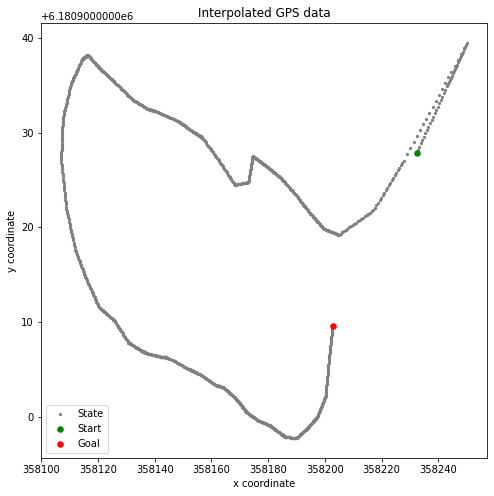

In [13]:
time = acc_time
# we have data from sensors with different shapes. So, we should interpolate the GPS data
# in order to get the same shape as accelerometer data

x = np.interp(time, gps_time, gps_x)
y = np.interp(time, gps_time, gps_y)

plot_xy(x, y, 'x coordinate', 'y coordinate', 'Interpolated GPS data')

## Theory

  We have already implemented one dimensional Kalman Filter. But now we have
the mean and the variance inside a matrix on which all the operations are performed. And we have sensor fusion, so, this results in a Kalman filter with the
following state variables (**System state X**).  
  
  At the beginning we will have to initialize with an initial state.
$$
x=\left[\begin{array}{c}
x \\
y \\
\dot{x} \\
\dot{y}
\end{array}\right]
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; I could take x and y from gps data. Also, I decided to take velocities $\dot{x}$ and
$\dot{y}$ equal to zero. Because I started recoring data from sensors when I had zero
velocity.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Also, an uncertainty must be given for the initial state - **covariance matrix
P**. This matrix is most likely to be changed during the filter passes. It’s changed
in both the predict and correction steps. I assumed that my sensors are very
accurate, so initially I put zeros here.  

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The core of the filter, however, is the following definition, which we should set
up with great understanding of the physical context. In our case, the dynamics in
matrix notation (**Dynamics matrix A**) is as follows:
$$
\mathbf{A}=\left[\begin{array}{cccc}
1 & 0 & d t & 0 \\
0 & 1 & 0 & d t \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{array}\right]
$$  

where dt - calculatation step  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; This states “where” the state vector moves from one calculation step to the next
within.  
$$ \mathbf{x}_{t+1}=\mathbf{A} \mathbf{x}_{t} $$


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; As the movement of phone may also be disturbed, this is where the process
**noise co-variance matrix Q** is introduced. This matrix tells us about the filter, and how the system state can “jump” from one step to the next. Imagine the
vehicle that drives autonomously. The matrix is a co-variance matrix containing
the following elements:
$$ 
\mathbf{Q}=\left[\begin{array}{cccc}
\sigma_{x}^{2} & \sigma_{x y} & \sigma_{x \dot{x}} & \sigma_{x \dot{y}} \\
\sigma_{y x} & \sigma_{y}^{2} & \sigma_{y \dot{x}} & \sigma_{y \dot{y}} \\
\sigma_{\dot{x} x} & \sigma_{\dot{x} y} & \sigma_{\dot{x}}^{2} & \sigma_{\dot{x} \dot{y}} \\
\sigma_{\dot{y} x} & \sigma_{\dot{y} y} & \sigma_{\dot{y} \dot{x}} & \sigma_{\dot{y}}^{2}
\end{array}\right]
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; An external control variables is possible via the **control matrix B**. The **matrix u** will contain the robotic input of the system which could be the instantaneous acceleration from IMU.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The filter must also be told what is measured and how it relates to the state
vector. So, let’s introduce measuring matrix H. We measure position in x and y.
$$
\mathbf{H}=\left[\begin{array}{llll}
1 & 0 & d t & 0 \\
0 & 1 & 0 & 0
\end{array}\right]
$$

A measurement uncerainty must also be stated here. This measurement uncertainty indicates how much one trusts the measured values of the sensors.  
$$
\mathbf{R}=\left[\begin{array}{ll}
\sigma_{x}^{2} & 0 \\
0 & \sigma_{y}^{2}
\end{array}\right]
$$
Additionally, we have control by using acceleration, because we know the law.
$$
\mathbf{B}=\left[\begin{array}{cc}
\frac{d t^{2}}{2} & 0 \\
0 & \frac{d t^{2}}{2} \\
d t & 0 \\
0 & d t
\end{array}\right]
$$

### Kalman algorithm

#### Prediction part

- State vector prediction
$$ 
\mathbf{X}_{k p}=\mathbf{A} \mathbf{X}_{k-1}+\mathbf{B} \mathbf{u}_{k}+\mathbf{w}_{k} $$

$w_k$ - noise of the model, it’s represented as vector:
$$
\mathbf{w}_{k}=\left[\begin{array}{c}
\sigma_{x} \\
\sigma_{y} \\
\sigma_{\dot{x}} \\
\sigma_{\dot{y}}
\end{array}\right]
$$

- State covariation matrix prediction
$$ \mathbf{P}_{k p}=\mathbf{A} \mathbf{P}_{k-1} \mathbf{A}+\mathbf{Q}_{k} $$

#### Correction part

- Kalman Gain
$$ \mathbf{K}=\frac{\mathbf{P}_{k p} \mathbf{H}^{T}}{\mathbf{H P}_{k p} \mathbf{H}^{T}+\mathbf{R}} $$

- Measurements 
$$ \mathbf{Y}_{k}=\mathbf{C Y}_{k m}+\mathbf{Z}_{m} $$

It’s the data from GPS. C matrix shows, which parameters from state
vector we are measuring.


- Update State Vector
$$ \mathbf{X}_{k}=\mathbf{X}_{k p}+\mathbf{K}\left[\mathbf{Y}-\mathbf{H} \mathbf{X}_{k p}\right] $$

- Update the covariation state matrix
$$ \mathbf{P}_{k}=(\mathbf{I}-\mathbf{K H}) \mathbf{P}_{k p} $$

In [14]:
# Let's introduce the means and stds of our measurements and process
std_x = x.std()
mean_x = x.mean()
std_y = y.std()
mean_y = y.mean()
std_ddx = ddx.std()
mean_ddx = ddx.mean()
std_ddy = ddy.std()
mean_ddy = ddy.mean()

#GUESS Correction
# Error in gps
std_x = 25
std_y = 25

# #GUESS Correction
# # Error in accelerator
std_ddx = 7
std_ddy = 7


# Measurement noise covariance matrix R
def matrix_R(std_x, std_y):
    R = np.array([[std_x**2, 0],
                  [0, std_y**2]], dtype=float)
    R = R.reshape(2, 2)
    return R

# Process noise co-variance matrix Q 
def matrix_Q(std_ddx, std_ddy, dt):
    sigma_x = std_ddx*(dt**2)/2
    sigma_y = std_ddy*(dt**2)/2
    sigma_dx = std_ddx*dt
    sigma_dy = std_ddy*dt
    Q = np.array([[sigma_x**2, 0, sigma_x*sigma_dx, 0],
                  [0, sigma_y**2, 0, sigma_y*sigma_dy],
                  [sigma_x*sigma_dx, 0, sigma_dx**2, 0],
                  [0, sigma_y*sigma_dy, 0, sigma_dy**2]], dtype=float)
    Q = Q.reshape(4, 4)
    return Q

# State vector X [x, y, dx, dy]
def vector_X(x, y, dx, dy):
    X = np.array([[x],
                  [y],
                  [dx],
                  [dy]], dtype=float)
    X = X.reshape(4, 1)
    return X

# Dynamics matrix A
def matrix_A(dt):
    A = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=float)
    A = A.reshape(4, 4)
    return A

# Control Matrix
def matrix_B(dt):
    B = np.array([[(dt**2)/2, 0],
                  [0, (dt**2)/2],
                  [dt, 0],
                  [0, dt]], dtype=float)
    B = B.reshape(4, 2)
    return B

# Control Input u
def vector_u(ddx, ddy, dt):
    u = np.array([[ddx],
                  [ddy]], dtype=float)
    u = u.reshape(2, 1)
    return u

# Observation Matrix
def matrix_C():
    C = np.array([[1, 0],
                  [0, 1]], dtype=float)
    C = C.reshape(2, 2)
    return C

# Measuring Matrix
def matrix_H():
    H = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0]], dtype=float)
    H = H.reshape(2, 4)
    return H

# Matrix of measurements' noise
def vector_Z(std_x, std_y):
    Z = np.array([[np.random.normal(loc = 0, scale = std_x)],
                  [np.random.normal(loc = 0, scale = std_y)]], dtype=float)
    Z = Z.reshape(2, 1)
    return Z

# Matrix of process' noise
def vector_W(std_ddx, std_ddy, dt):
    sigma_x = std_ddx*(dt**2)/2
    sigma_y = std_ddy*(dt**2)/2
    sigma_dx = std_ddx*dt
    sigma_dy = std_ddy*dt
    W = np.array([[np.random.normal(loc = 0, scale = sigma_x)],
                  [np.random.normal(loc = 0, scale = sigma_y)],
                  [np.random.normal(loc = 0, scale = sigma_dx)],
                  [np.random.normal(loc = 0, scale = sigma_dy)]], dtype=float)
    W = W.reshape(4, 1)
    return W

# Co-variance matrix P
def vector_P():
    P = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]], dtype=float)
    P = P.reshape(4, 4)
    return P

In [15]:
n = time.shape[0] - 1
u = np.zeros((2,n), dtype=float)

time = time/1000
dt = []

for i in range(n):
    dt.append(time[i+1] - time[i])
    u_i = vector_u(ddx[i], ddy[i], dt[i])
    u[:, i] = u_i[:, 0]
    
dt = np.array(dt)

Ym = np.array([x[0:-1], y[0:-1]])

C = matrix_C()
R = matrix_R(std_x, std_y)
H = matrix_H()

X_0 = vector_X(x[0], y[0], 0, 0)
X = np.zeros((4,n), dtype=float)
X[:, 0] = X_0[:, 0]

def Kalman_algorithm():
    Kalman_list = []
    P = vector_P()
    for i in range(n-1):
        A = matrix_A(dt[i])
        B = matrix_B(dt[i])
        Q = matrix_Q(std_ddx, std_ddy, dt[i])
        Z = vector_Z(std_x, std_y)
        W = vector_W(std_ddx, std_ddy, dt[i])
        # PREDICTION
        # Calculate the state pred.
        X_pred = np.matmul(A, X[:, i]) + np.matmul(B, u[:, i]) #+ W[:, 0]
        # Calculate the covariance matrix
        P = np.matmul(A, np.matmul(P, A.transpose())) + Q

        # CORRECTION
        # Compute the Kalman gain
        K = np.matmul(np.matmul(P, H.transpose()), np.linalg.pinv(np.matmul(H, np.matmul(P, H.transpose())) + R))
        # Compute the measurements
        Y = np.matmul(C, Ym[:, i]).reshape(-1,1) #+ Z
        # Update state extimate
        x = X_pred.reshape(-1, 1) + np.matmul(K, Y - np.matmul(H, X_pred).reshape(-1,1))
        X[:, i+1] = x.reshape(-1,)
        # Update the covariance matrix
        P = np.matmul((np.eye(4, k=0) - np.matmul(K, H)), P)
        Kalman_list.append(K)
        Kalman_gains = np.array(Kalman_list)
    return X, Kalman_gains


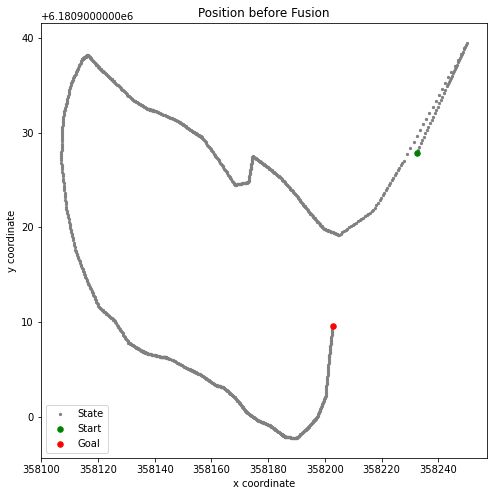

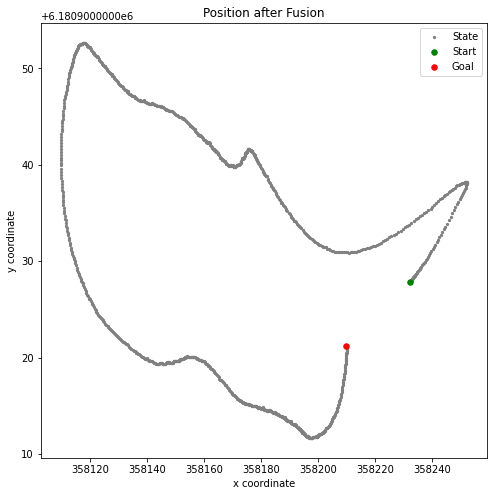

In [16]:
X, Kalman_gains = Kalman_algorithm()
plot_xy(x,y, 'x coordinate', 'y coordinate', 'Position before Fusion')
plot_xy(X[0], X[1], 'x coordinate', 'y coordinate', 'Position after Fusion')